# Install Dependencies


In [1]:
# Install Condacolab to integrate Conda with Colab
!pip install -q condacolab

# Import and run Condacolab to enable Conda
import condacolab
condacolab.install()

# Install pmdarima from conda-forge using Conda
!conda install -c conda-forge pmdarima -y

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pmdarima


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.7.14  |       hbd8a1cb_0         152 KB  conda-forge
    certifi-2025.7.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    cython-3.1.2               |  py311ha3e34f5_2         3.5 MB  conda-forge
    joblib-1.5.1               |     pyhd8ed1ab_0         219 KB  conda-forge
    libblas-3.9.0              

In [1]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 147.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 156.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 149.5 MB/s eta 0:00:00


# Import Packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from pmdarima import auto_arima
import logging
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import pickle
import json
import os

warnings.filterwarnings("ignore", category=FutureWarning)


# Bitcoin Dataset

In [2]:
# Define the ticker symbol (e.g., BTC-USD for Bitcoin in USD)
ticker_symbol = "BTC-USD"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical data from 2011-01-01 to 2025-06-10
btc = ticker.history(start="2011-01-01", end="2025-06-10")

# Reset index to make 'Date' a column (Timestamp)
btc = btc.reset_index()

# Convert 'Date' to string with only YYYY-MM-DD format (remove time)
btc['Date'] = btc['Date'].dt.strftime('%Y-%m-%d')

# Select the desired columns
# Note: yfinance provides 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Check if all requested columns exist in the data
available_columns = [col for col in columns if col in btc.columns]
btc = btc[available_columns]

# Rename 'Volume' to 'Volume_(Currency)'
btc = btc.rename(columns={'Volume': 'Volume_(Currency)'})

# Rename 'Date' to 'Timestamp'
btc = btc.rename(columns={'Date': 'Timestamp'})

# Reorder columns to match the requested order
final_columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(Currency)']
btc = btc[final_columns]

# Display the resulting DataFrame
print(btc)

# Optionally, save to a CSV file
btc.to_csv('btc_data_2011_2025.csv', index=False)

       Timestamp           Open           High            Low          Close  \
0     2014-09-17     465.864014     468.174011     452.421997     457.334015   
1     2014-09-18     456.859985     456.859985     413.104004     424.440002   
2     2014-09-19     424.102997     427.834991     384.532013     394.795990   
3     2014-09-20     394.673004     423.295990     389.882996     408.903992   
4     2014-09-21     408.084991     412.425995     393.181000     398.821014   
...          ...            ...            ...            ...            ...   
3914  2025-06-05  104750.781250  105936.687500  100436.882812  101575.953125   
3915  2025-06-06  101574.367188  105376.773438  101169.570312  104390.343750   
3916  2025-06-07  104390.648438  105972.757812  103987.312500  105615.625000   
3917  2025-06-08  105617.507812  106497.062500  105075.328125  105793.648438   
3918  2025-06-09  105793.023438  110561.421875  105400.234375  110294.101562   

      Volume_(Currency)  
0            

In [3]:
df = btc.copy()

In [4]:
df.shape

(3919, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          3919 non-null   object 
 1   Open               3919 non-null   float64
 2   High               3919 non-null   float64
 3   Low                3919 non-null   float64
 4   Close              3919 non-null   float64
 5   Volume_(Currency)  3919 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 183.8+ KB


In [6]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(Currency)
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


# Plotting Data

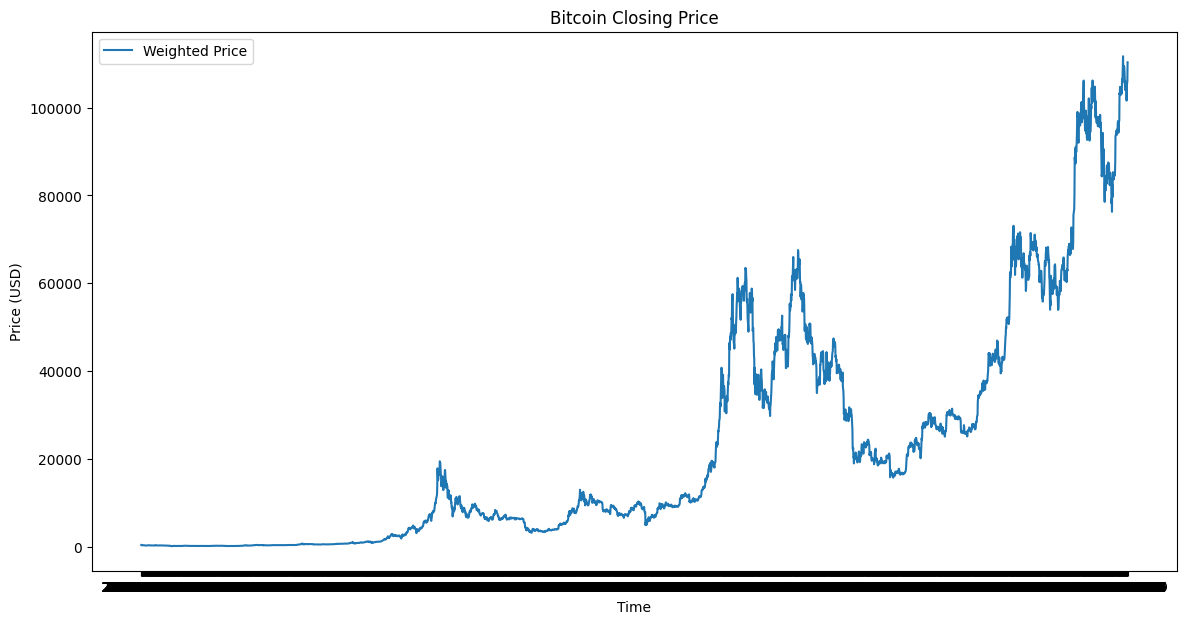

In [7]:
bitstamp_indexed = df.set_index("Timestamp")
weighted_price = bitstamp_indexed["Close"]
plt.figure(figsize=(14, 7))
plt.plot(weighted_price, label="Weighted Price")

plt.title("Bitcoin Closing Price")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Handling Missing Values

In [8]:
# Step 1: Count how many missing (NaN) values are in each column
total_missing = df.isnull().sum()

# Step 2: Calculate the percentage of missing values for each column
missing_percentage = (total_missing / len(df)) * 100

missing_table = pd.concat([total_missing, missing_percentage], axis=1)
missing_table.columns = ['Total Missing Values', 'Missing %']


In [9]:
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume_(Currency),0,0.0


## No null value

# Exploratory Data Analysis

<Axes: xlabel='Close', ylabel='Density'>

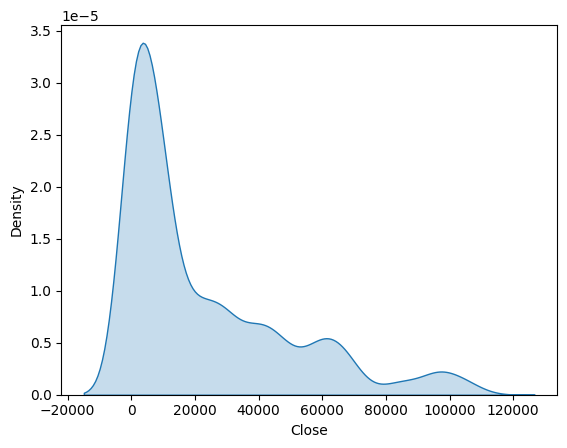

In [10]:
sns.kdeplot(df['Close'], shade=True)

## Visualize using lag plot

Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better.

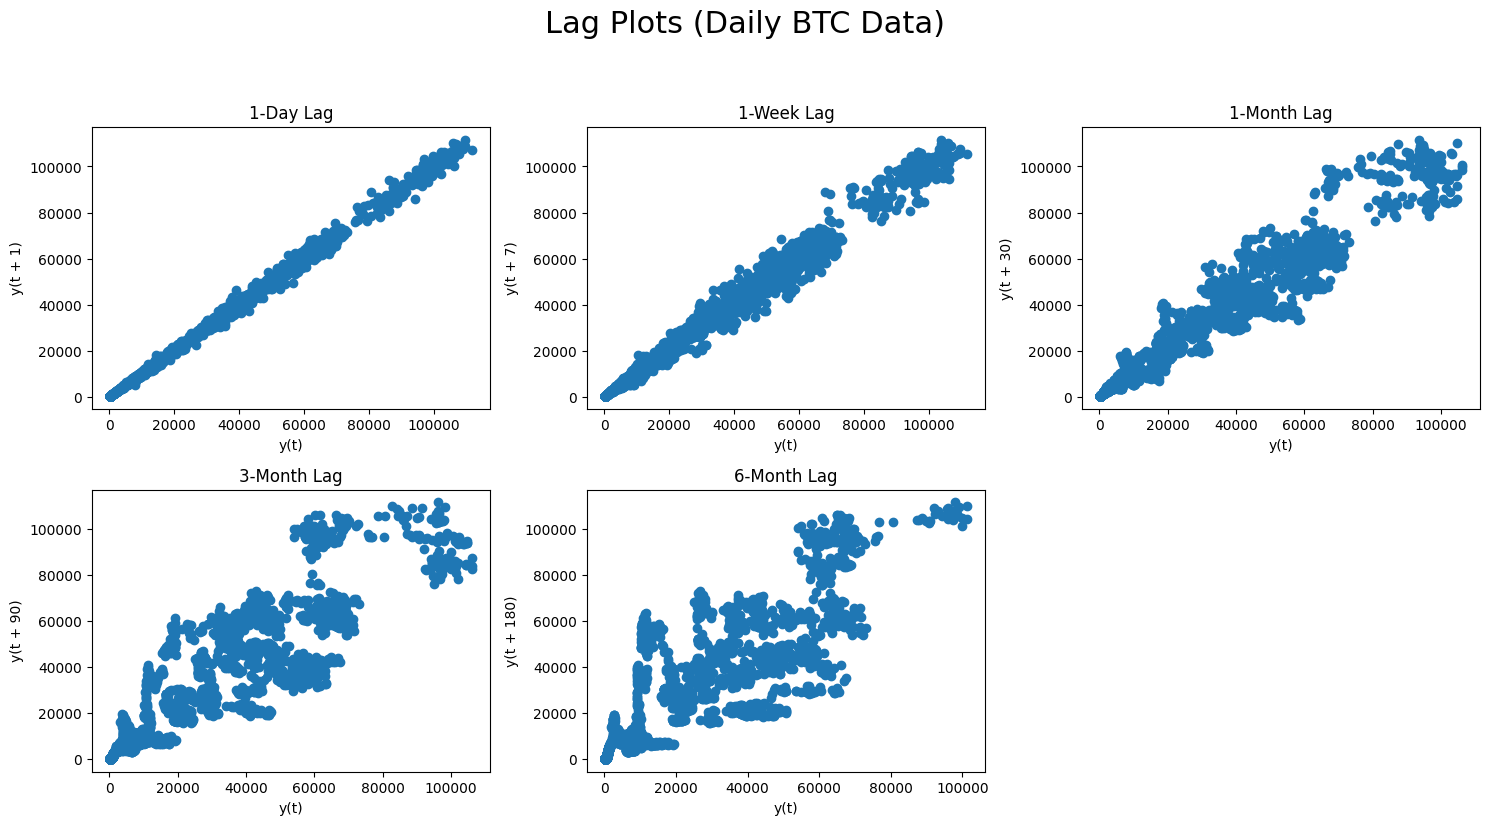

In [11]:
plt.figure(figsize=(15, 12))
plt.suptitle('Lag Plots (Daily BTC Data)', fontsize=22)

lags = [1, 7, 30, 90, 180]  # Daily lags: 1-day, 1-week, 1-month, etc.
titles = ['1-Day Lag', '1-Week Lag', '1-Month Lag', '3-Month Lag', '6-Month Lag']

for i, (lag, title) in enumerate(zip(lags, titles), start=1):
    plt.subplot(3, 3, i)
    pd.plotting.lag_plot(btc['Close'], lag=lag)
    plt.title(title)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


We can see that there is a positive correlation for daily, weekly and monthly lag plots. We observe less correlation for 3,6 month lag plots.


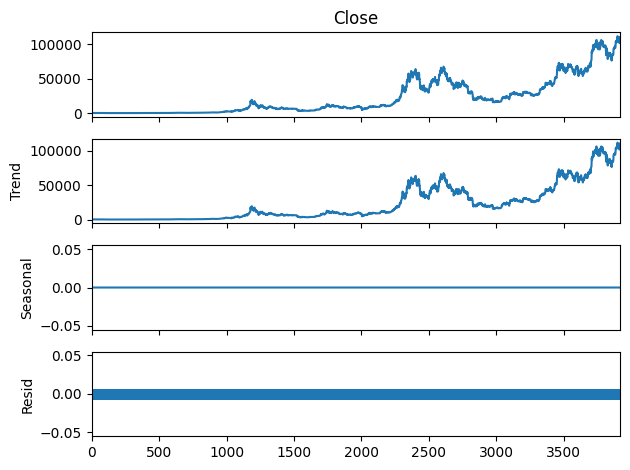

<Figure size 1500x1200 with 0 Axes>

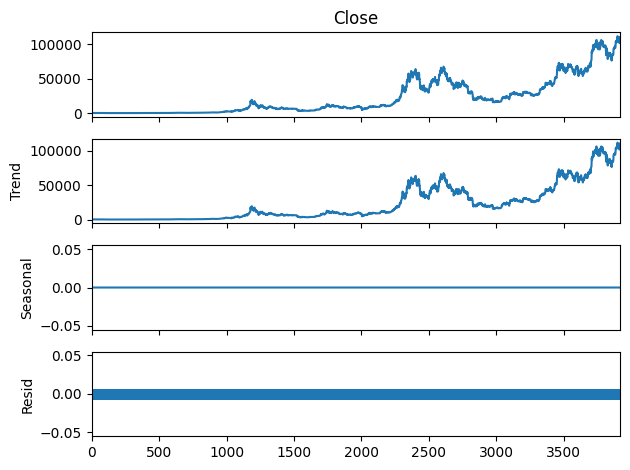

In [12]:
plt.figure(figsize=(15,12))
series = df.Close
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

## 📉 Time Series Decomposition Analysis

After decomposing the time series of the **Close** prices, we observe the following:

### 🔍 Observations

- **Trend**:  
  A clear upward trend is present, especially in the later part of the series, indicating long-term growth in prices.

- **Seasonality**:  
  No visible seasonal component is detected. The seasonal plot remains flat, suggesting the absence of regular periodic patterns.

- **Residuals**:  
  The residual component fluctuates around zero but does not appear to carry any structure or cyclical behavior.

- **Non-Stationarity**:  
  The series shows **changing mean and variance over time**, which indicates it is likely **non-stationary**. This implies that standard statistical modeling techniques may not be valid without transformation.

---

## 🧪 Next Steps

To validate the non-stationarity of the series, we will apply the following statistical tests:

- **KPSS Test** (Kwiatkowski–Phillips–Schmidt–Shin)
- **ADF Test** (Augmented Dickey-Fuller)

---

## 🔁 Autocorrelation Analysis

Before running the tests, let’s visualize the temporal structure using:

- **ACF (Autocorrelation Function)**
- **PACF (Partial Autocorrelation Function)**

These plots help us understand the correlation between time steps and guide us in selecting appropriate models for forecasting.


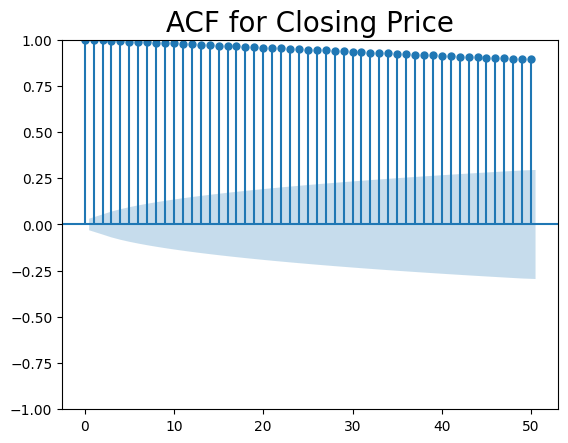

In [13]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Closing Price", size=20)
plt.show()

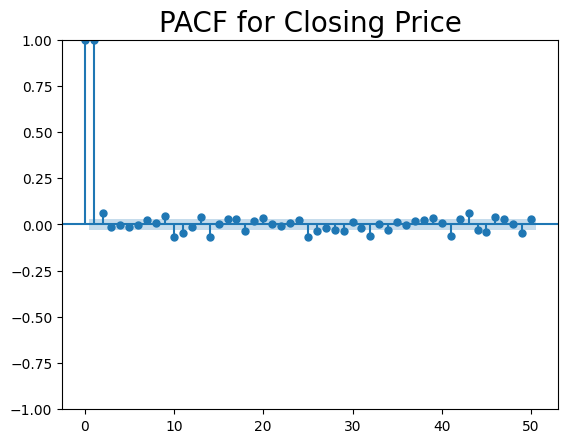

In [14]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Closing Price", size=20)
plt.show()

## 🔁 ACF and PACF Analysis

### ACF (Autocorrelation Function)
The ACF plot shows strong and persistent autocorrelations at all lags, with no significant decay. This suggests that the time series is **non-stationary**, and past values have a prolonged influence over future values. Such behavior often indicates the need for **differencing** to achieve stationarity before modeling.

### PACF (Partial Autocorrelation Function)
The PACF plot shows a sharp spike at lag 1 and minor spikes up to lag 3–5, with all further lags remaining within the confidence bounds. This implies that **only the first few lags have a significant direct effect** on the current value. Models like **AR(1)** or **AR(2)** may be suitable, while including more lags could lead to overfitting without much gain.

---

Based on both ACF and PACF, we proceed by differencing the series and re-checking stationarity before fitting ARIMA-type models.


# KPSS Test

The KPSS test (Kwiatkowski–Phillips–Schmidt–Shin) is a statistical test used to check whether a time series is stationary around a deterministic trend.
In this test, the null hypothesis assumes that the series is stationary.
So, if the p-value is less than the chosen significance level (e.g., 0.05), we reject the null hypothesis, meaning the series is not stationary. If the p-value is higher, we fail to reject the null, suggesting the series is stationary.

The KPSS test output includes four key components:

1. **KPSS Statistic**: This is the test statistic calculated during the KPSS test.  
2. **p-value**: The probability value used to determine whether to reject the null hypothesis.  
3. **Number of Lags**: The number of lagged observations from the series that the test model uses.  
4. **Critical Values**: Threshold values at different significance levels for the test statistic.

The p-value indicates the likelihood of observing the test results under the null hypothesis. Typically, if the p-value is less than a chosen significance level (commonly 0.05), the null hypothesis is rejected.

The null hypothesis in the KPSS test assumes that the series is stationary. To reject this hypothesis, the KPSS statistic must exceed the corresponding critical value at the desired significance level. When the test statistic is greater than the 5% critical value, it corresponds to a low p-value (less than 0.05), signaling that the series is likely non-stationary.


In [15]:
stats, p, lags, critical_values = kpss(series, 'ct')

/tmp/ipython-input-15-4055464602.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stats, p, lags, critical_values = kpss(series, 'ct')


In [16]:
print('Test Statistics :', stats)
print('p-value :', p)
print('Critical Values :', critical_values)

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')


Test Statistics : 0.7844418915379052
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


### KPSS Test Results Explanation

- **Test Statistic**: 0.7844  
- **p-value**: 0.01  
- **Critical Values**:  
  - 10%: 0.119  
  - 5%: 0.146  
  - 2.5%: 0.176  
  - 1%: 0.216  

---

The **KPSS test statistic** of 0.7998 is much greater than the 5% critical value of 0.146. This means the test statistic lies well beyond the threshold for rejecting the null hypothesis.

The **p-value** of 0.01 is less than the common significance level of 0.05, indicating strong evidence against the null hypothesis.

Since the null hypothesis for the KPSS test assumes that the series is stationary, rejecting it means the series **is not stationary**.

In summary, based on these results, the time series exhibits non-stationarity.


# ADF Test

The key difference lies in the **null hypothesis** of the two tests, which are essentially opposite:

- In the **KPSS test**, the null hypothesis assumes the series **is stationary** (no unit root).
- In contrast, the other test (such as the **Augmented Dickey-Fuller (ADF) test**) has the null hypothesis that the series **has a unit root**, meaning it is **non-stationary**.

Therefore, while KPSS tests for stationarity directly, tests like ADF check for non-stationarity. This difference is important when interpreting results, as rejecting the null means opposite conclusions depending on the test used.


In [17]:
print('Results of Dickey-Fuller Test:')

# Perform the test
dftest = adfuller(series, autolag='AIC')

# Extract test results
test_statistic = dftest[0]
p_value = dftest[1]
num_lags = dftest[2]
num_obs = dftest[3]
critical_values = dftest[4]

# Create a summary series
dfoutput = pd.Series({
    'Test Statistic': test_statistic,
    'p-value': p_value,
    '# Lags Used': num_lags,
    'Number of Observations Used': num_obs
})

# Add critical values to the summary
for key, value in critical_values.items():
    dfoutput[f'Critical Value ({key})'] = value

print(dfoutput)

# Interpret the p-value
if p_value > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Results of Dickey-Fuller Test:
Test Statistic                    0.262852
p-value                           0.975574
# Lags Used                      31.000000
Number of Observations Used    3887.000000
Critical Value (1%)              -3.432033
Critical Value (5%)              -2.862284
Critical Value (10%)             -2.567166
dtype: float64
Series is not Stationary


# Conclusion

KPSS says series is not stationary and ADF says series is not stationary. Make it stationary using differencing for ARIMA

# Feature Extraction

### Rolling Windows

Time series data often contains significant noise due to daily market fluctuations, making it difficult to identify clear trends or patterns.

To smooth out this noise, we can apply a **rolling mean** (also known as a **moving average**), which averages data over a specified time window. This technique helps reveal underlying trends by reducing short-term volatility.

The rolling operation slides a window of fixed size over the data and applies an aggregation function—such as `mean()`, `median()`, or `count()`—to each window. In our case, we’ll use a **rolling mean** with window sizes of **3, 7, and 30 days** to observe short-, medium-, and long-term trends in the data.


In [18]:

# Define features and rolling window sizes
lag_features = ["Open", "High", "Low", "Close", "Volume_(Currency)"]
windows = [3, 7, 30]

# Compute rolling statistics (mean and std) for each window size and feature
for window in windows:
    rolled = df[lag_features].rolling(window=window, min_periods=1)

    # Calculate shifted rolling mean and std
    rolled_mean = rolled.mean().shift(1)
    rolled_std = rolled.std().shift(1)

    # Assign new features to dataframe
    for feature in lag_features:
        df[f"{feature}_mean_lag{window}"] = rolled_mean[feature]
        df[f"{feature}_std_lag{window}"] = rolled_std[feature]

# Fill any remaining NaN values with column-wise mean (only for numeric columns)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Restore original index
df.set_index("Timestamp", drop=False, inplace=True)

# Display the first few rows
df.head()


,Timestamp,Open,High,Low,Close,Volume_(Currency),Open_mean_lag3,Open_std_lag3,High_mean_lag3,High_std_lag3,...,Open_mean_lag30,Open_std_lag30,High_mean_lag30,High_std_lag30,Low_mean_lag30,Low_std_lag30,Close_mean_lag30,Close_std_lag30,Volume_(Currency)_mean_lag30,Volume_(Currency)_std_lag30
Timestamp,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,22580.005228,460.721160,23071.460279,407.689260,...,22216.302628,1456.290213,22703.193450,1453.168467,21707.792318,1451.369339,22241.994704,1457.521699,1.940640e+10,6.309771e+09
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,465.864014,460.721160,468.174011,407.689260,...,465.864014,1456.290213,468.174011,1453.168467,452.421997,1451.369339,457.334015,1457.521699,2.105680e+07,6.309771e+09
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,461.362000,6.366809,462.516998,8.000224,...,461.362000,6.366809,462.516998,8.000224,432.763000,27.802020,440.887009,23.259579,2.777000e+07,9.493898e+06
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,448.942332,21.977547,450.956329,20.807426,...,448.942332,21.977547,450.956329,20.807426,416.686005,34.086442,425.523336,31.283084,3.115323e+07,8.910996e+06
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,425.211995,31.108320,435.996989,18.209863,...,435.375000,32.531498,444.041245,21.906763,409.985252,30.889977,421.368500,26.860222,3.258082e+07,7.815965e+06


Our data becomes a lot less noisy and more reflective of the trend than the data itself on using moving average

# Extract Data Time Features

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3919 entries, 2014-09-17 to 2025-06-09
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     3919 non-null   object 
 1   Open                          3919 non-null   float64
 2   High                          3919 non-null   float64
 3   Low                           3919 non-null   float64
 4   Close                         3919 non-null   float64
 5   Volume_(Currency)             3919 non-null   int64  
 6   Open_mean_lag3                3919 non-null   float64
 7   Open_std_lag3                 3919 non-null   float64
 8   High_mean_lag3                3919 non-null   float64
 9   High_std_lag3                 3919 non-null   float64
 10  Low_mean_lag3                 3919 non-null   float64
 11  Low_std_lag3                  3919 non-null   float64
 12  Close_mean_lag3               3919 non-null   float6

In [20]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [21]:
df["month"] = df["Timestamp"].dt.month
df["week"] = df["Timestamp"].dt.isocalendar().week
df["day"] = df["Timestamp"].dt.day
df["day_of_week"] = df["Timestamp"].dt.dayofweek

df.head()


,Timestamp,Open,High,Low,Close,Volume_(Currency),Open_mean_lag3,Open_std_lag3,High_mean_lag3,High_std_lag3,...,Low_mean_lag30,Low_std_lag30,Close_mean_lag30,Close_std_lag30,Volume_(Currency)_mean_lag30,Volume_(Currency)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,22580.005228,460.721160,23071.460279,407.689260,...,21707.792318,1451.369339,22241.994704,1457.521699,1.940640e+10,6.309771e+09,9,38,17,2
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,465.864014,460.721160,468.174011,407.689260,...,452.421997,1451.369339,457.334015,1457.521699,2.105680e+07,6.309771e+09,9,38,18,3
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,461.362000,6.366809,462.516998,8.000224,...,432.763000,27.802020,440.887009,23.259579,2.777000e+07,9.493898e+06,9,38,19,4
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,448.942332,21.977547,450.956329,20.807426,...,416.686005,34.086442,425.523336,31.283084,3.115323e+07,8.910996e+06,9,38,20,5
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,425.211995,31.108320,435.996989,18.209863,...,409.985252,30.889977,421.368500,26.860222,3.258082e+07,7.815965e+06,9,38,21,6


# Model Building

## Cross Validation

### Time Series Forecasting: Data Splitting and Validation

To evaluate a forecasting model, we typically split the time series into **training** and **validation** sets — this is known as **fixed partitioning**.

#### Key Points:

- If the data has **seasonality** (e.g., yearly cycles), ensure each split contains **whole seasons** (like full years) to avoid bias.
- Example:
  - **Training Set**: 2014–2023
  - **Validation (Hold-out) Set**: 2024 - 2025

#### Process:

1. **Train** the model on the training data.
2. **Tune** the model and adjust hyperparameters using the validation set.
3. Once satisfied, **retrain** on both training + validation data.
4. Optionally, include the **test set** for final training, as it's the most recent and helps capture the latest trends.

> This method is called **hold-out validation** and is widely used in time series forecasting.




In [22]:
df_train = df[df.Timestamp < "2023"]
df_valid = df[df.Timestamp >= "2023"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (3028, 40)
validation shape : (891, 40)


# ARIMA

## ARIMA Explained

**ARIMA** stands for **AutoRegressive Integrated Moving Average**. It's a widely used model in time series forecasting that captures key patterns and structures in temporal data.

### 📌 Components of ARIMA:

- **AR (AutoRegression)**  
  Uses the relationship between an observation and its previous values (lags).

- **I (Integrated)**  
  Involves differencing the data to make the series stationary — that is, removing trends or seasonality.

- **MA (Moving Average)**  
  Models the relationship between an observation and the residual errors from past forecasts.

---

### 🧮 ARIMA Notation: ARIMA(p, d, q)

- **p**: Number of lag observations (autoregressive order)
- **d**: Number of times the data needs to be differenced to become stationary
- **q**: Size of the moving average window (order of moving average)

This notation helps summarize the configuration of an ARIMA model.




In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3028 entries, 2014-09-17 to 2022-12-31
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     3028 non-null   datetime64[ns]
 1   Open                          3028 non-null   float64       
 2   High                          3028 non-null   float64       
 3   Low                           3028 non-null   float64       
 4   Close                         3028 non-null   float64       
 5   Volume_(Currency)             3028 non-null   int64         
 6   Open_mean_lag3                3028 non-null   float64       
 7   Open_std_lag3                 3028 non-null   float64       
 8   High_mean_lag3                3028 non-null   float64       
 9   High_std_lag3                 3028 non-null   float64       
 10  Low_mean_lag3                 3028 non-null   float64       
 11  Low_std_lag3        

In [24]:

# -----------------------------
# Define target and features
# -----------------------------
target_col = 'Close'
exogenous_features = [
    'Open_mean_lag3', 'Open_mean_lag7', 'Open_mean_lag30',
    'Open_std_lag3', 'Open_std_lag7', 'Open_std_lag30',
    'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
    'High_std_lag3', 'High_std_lag7', 'High_std_lag30',
    'Low_mean_lag3', 'Low_mean_lag7', 'Low_mean_lag30',
    'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
    'Close_mean_lag3', 'Close_mean_lag7', 'Close_mean_lag30',
    'Close_std_lag3', 'Close_std_lag7', 'Close_std_lag30',
    'Volume_(Currency)_mean_lag3', 'Volume_(Currency)_mean_lag7', 'Volume_(Currency)_mean_lag30',
    'Volume_(Currency)_std_lag3', 'Volume_(Currency)_std_lag7', 'Volume_(Currency)_std_lag30',
    'month', 'week', 'day', 'day_of_week'
]

Running auto_arima to determine best (p,d,q)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=49005.647, Time=21.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49025.108, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49025.126, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49025.146, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49023.243, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=49027.478, Time=3.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=49029.081, Time=1.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=49007.624, Time=10.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=49007.684, Time=7.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=49027.113, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=49027.755, Time=2.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=49027.969, Time=1.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=49009.329, Time=7.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Validation RMSE: 43172.3106
Validation MAE: 35332.3612
Validation R² Score: -1.5582


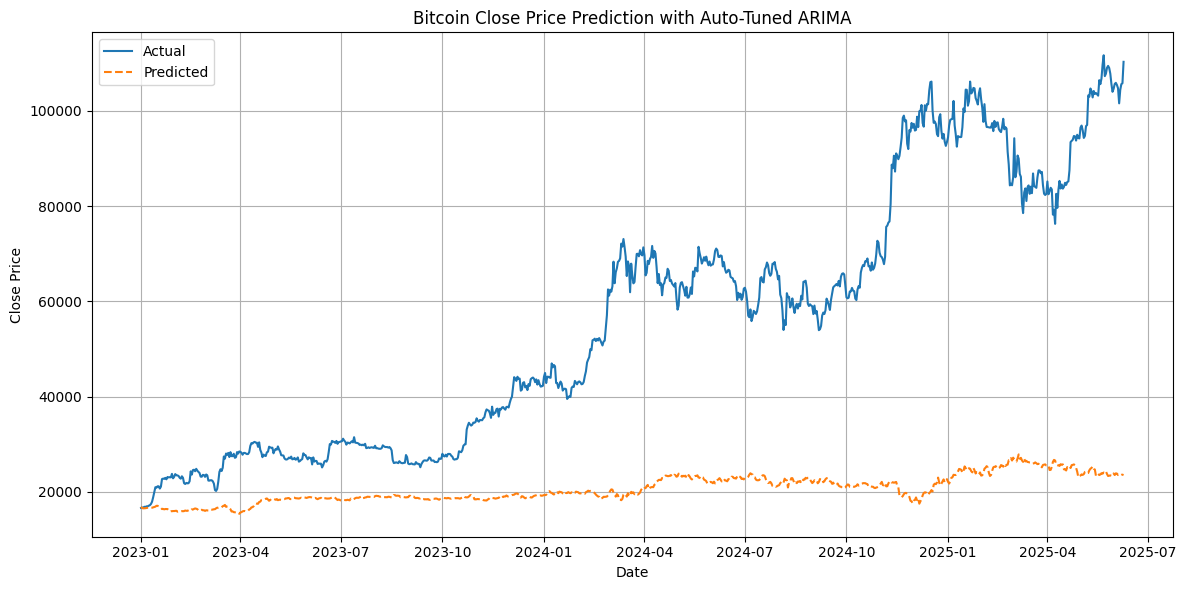

In [ ]:
# -----------------------------
# Clean and prepare data
# -----------------------------
df_train_clean = df_train[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()
df_valid_clean = df_valid[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()

X_train = df_train_clean[exogenous_features].reset_index(drop=True)
y_train = df_train_clean[target_col].reset_index(drop=True).squeeze()

X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
y_valid = df_valid_clean[target_col].reset_index(drop=True).squeeze()

# -----------------------------
# Scale exogenous variables
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# -----------------------------
# Auto-tune ARIMA order
# -----------------------------
print("Running auto_arima to determine best (p,d,q)...")
auto_model = auto_arima(
    y=y_train,
    exogenous=X_train_scaled,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

order = auto_model.order
print(f"Selected ARIMA order: {order}")

# -----------------------------
# Fit ARIMA with best order
# -----------------------------
model = ARIMA(endog=y_train, exog=X_train_scaled, order=order)
model_fit = model.fit()

# -----------------------------
# Forecast and Evaluate
# -----------------------------
forecast = model_fit.predict(
    start=len(y_train),
    end=len(y_train) + len(y_valid) - 1,
    exog=X_valid_scaled
)

rmse = np.sqrt(mean_squared_error(y_valid, forecast))
mae = mean_absolute_error(y_valid, forecast)
r2 = r2_score(y_valid, forecast)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R² Score: {r2:.4f}')

# -----------------------------
# Plot actual vs predicted
# -----------------------------
plt.figure(figsize=(12, 6))

# Use timestamp if available, else fallback to index
if 'Timestamp' in df_valid.columns:
    time_axis = df_valid['Timestamp'].reset_index(drop=True)
else:
    time_axis = y_valid.index

plt.plot(time_axis, y_valid, label='Actual')
plt.plot(time_axis, forecast, label='Predicted', linestyle='--')
plt.title('Bitcoin Close Price Prediction with Auto-Tuned ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SARIMAX Explained

**SARIMAX** stands for **Seasonal AutoRegressive Integrated Moving Average with eXogenous variables**.  
It is an extension of ARIMA that incorporates **seasonality** and allows the inclusion of **external predictors**, making it suitable for more complex forecasting scenarios.

---

### 📌 Components of SARIMAX:

- **AR (AutoRegression)**  
  Models the current value as a function of its past values.

- **I (Integrated)**  
  Applies differencing to make the series stationary (i.e., remove trends).

- **MA (Moving Average)**  
  Models the current value as a function of past forecast errors.

- **S (Seasonality)**  
  Captures repeating patterns over time (e.g., weekly, yearly cycles).

- **X (eXogenous Variables)**  
  Incorporates external predictors (like other variables or lagged statistics) that help improve forecasts.

---

### 🧮 SARIMAX Notation: `SARIMAX(p, d, q) × (P, D, Q, s)`

- **(p, d, q)**: Non-seasonal ARIMA components  
- **(P, D, Q, s)**: Seasonal components  
  - **P**: Seasonal autoregressive order  
  - **D**: Seasonal differencing order  
  - **Q**: Seasonal moving average order  
  - **s**: Length of the seasonal cycle (e.g., `s = 12` for monthly data with yearly seasonality)

---

SARIMAX is especially useful when:
- The data has strong **seasonal** patterns.
- There are **known influencing factors** (exogenous variables).
- You want to combine **time series modeling** with **regression-like features**.



Running auto_arima to determine best (p,d,q)(P,D,Q,s)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=49021.406, Time=20.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=49025.108, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=49019.914, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=49019.809, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=49023.243, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=49025.146, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=49021.380, Time=2.27 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=49021.513, Time=3.32 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=49019.962, Time=0.62 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=49023.376, Time=8.14 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=49019.849, Time=0.64 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=49021.679, Time=6.86 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=49021.527, Time=1.19 sec
 ARIMA(1,1,0)(0,0,1)[7] inte

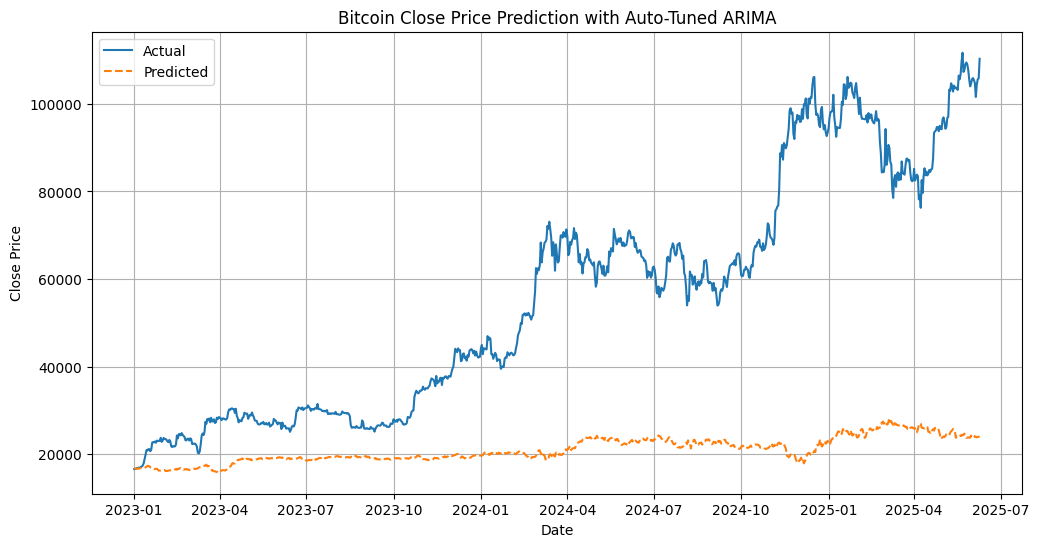

In [ ]:
# -----------------------------
# Clean and prepare data
# -----------------------------
df_train_clean = df_train[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()
df_valid_clean = df_valid[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()

X_train = df_train_clean[exogenous_features].reset_index(drop=True)
y_train = df_train_clean[target_col].reset_index(drop=True)

X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
y_valid = df_valid_clean[target_col].reset_index(drop=True)

# -----------------------------
# Scale exogenous variables
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# -----------------------------
# Auto-tune SARIMAX order
# -----------------------------
print("Running auto_arima to determine best (p,d,q)(P,D,Q,s)...")
auto_model = auto_arima(y=y_train, exogenous=X_train_scaled,
                        seasonal=True, m=7,   # change m based on your seasonality (e.g., 7 for weekly)
                        stepwise=True, suppress_warnings=True,
                        error_action='ignore', trace=True)

order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f"Selected SARIMA order: {order}")
print(f"Selected Seasonal order: {seasonal_order}")

# -----------------------------
# Fit SARIMAX with best order and exogenous variables
# -----------------------------
model = SARIMAX(endog=y_train, exog=X_train_scaled,
                order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# -----------------------------
# Forecast and Evaluate
# -----------------------------
forecast = model_fit.predict(start=len(y_train), end=len(y_train)+len(y_valid)-1, exog=X_valid_scaled)

rmse = np.sqrt(mean_squared_error(y_valid, forecast))
mae = mean_absolute_error(y_valid, forecast)
r2 = r2_score(y_valid, forecast)

print(f'Validation RMSE: {rmse:.4f}')
print(f'Validation MAE: {mae:.4f}')
print(f'Validation R² Score: {r2:.4f}')

# -----------------------------
# Plot actual vs predicted
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_valid['Timestamp'], y_valid, label='Actual')
plt.plot(df_valid['Timestamp'], forecast, label='Predicted', linestyle='--')
plt.title('Bitcoin Close Price Prediction with Auto-Tuned ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 🔁 Rolling SARIMAX Forecast

## ✅ What is Rolling SARIMAX?

A **rolling forecast** with SARIMAX is a step-by-step forecasting approach where the model is updated at each time step with new actual data before predicting the next time point.

---

## ⚙️ How It Works

1. Train SARIMAX on the initial training data  
2. Predict the next time point (e.g., day `t+1`)  
3. Add the actual observed value for `t+1` to the training set  
4. Retrain or update the model  
5. Repeat steps 2–4 for all future points

---

## 🎯 Advantages

- ✅ **Realistic Forecasting**  
  Simulates real-world forecasting where future values are unknown.

- ✅ **No Lookahead Bias**  
  Only past data is used at each prediction step.

- ✅ **Adapts to New Data**  
  Updates with recent values, useful in non-stationary time series.

- ✅ **Effective for Volatile Data**  
  Especially useful in financial, energy, and demand forecasting.

---

## ⚠️ Drawbacks

- ❌ **Computationally Expensive**  
  Model fitting is repeated at every time step.

- ❌ **More Complex Code**  
  Requires a loop and dynamic updating of the model's inputs.

---

## 📌 Use Cases

- 📈 Bitcoin / Stock price forecasting  
- 🔌 Energy load prediction  
- 📦 Supply chain demand estimation  
- 📅 Forecasting in real-time systems

---

## 🧠 Best Practice

> Use **Rolling SARIMAX** for validation or live forecasting scenarios where accuracy and realistic behavior matter more than speed.


Best order from auto_arima: (2, 1, 2)
Running rolling SARIMAX forecast...


Forecasting: 100%|██████████| 891/891 [3:17:26<00:00, 13.30s/it]


Rolling Forecast RMSE: 1643.7542
Rolling Forecast MAE: 1058.3386
Rolling Forecast R² Score: 0.9963


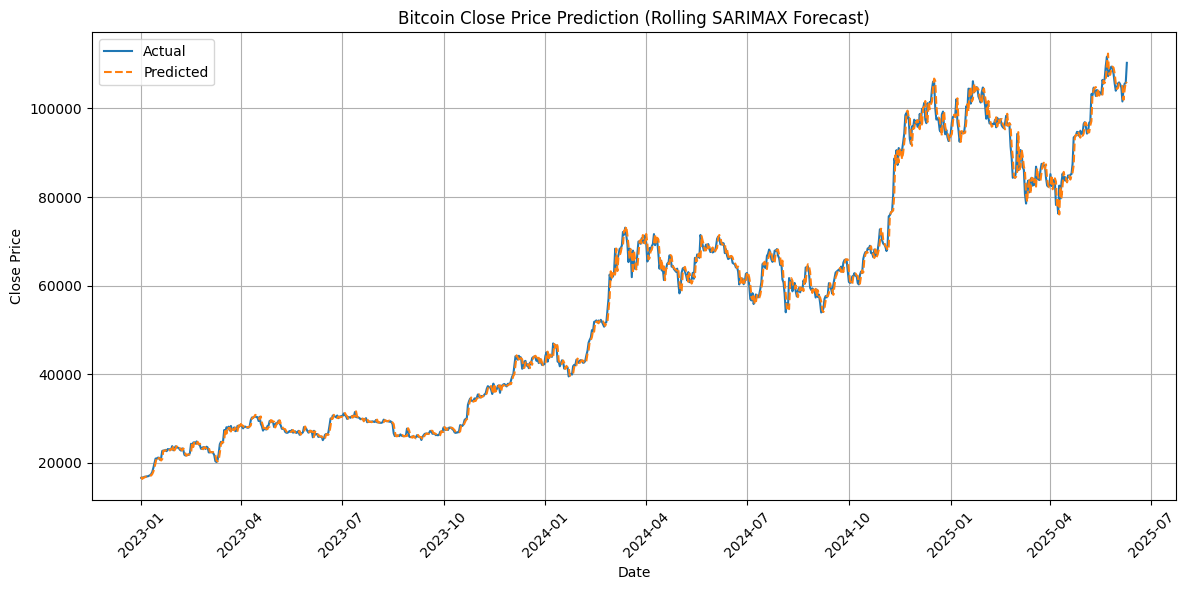

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Copy and setup
# -----------------------------
df1 = df.copy()
target_col = 'Close'
exogenous_features = [
    'Open_mean_lag3', 'Open_mean_lag7', 'Open_mean_lag30',
    'Open_std_lag3', 'Open_std_lag7', 'Open_std_lag30',
    'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
    'High_std_lag3', 'High_std_lag7', 'High_std_lag30',
    'Low_mean_lag3', 'Low_mean_lag7', 'Low_mean_lag30',
    'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
    'Close_mean_lag3', 'Close_mean_lag7', 'Close_mean_lag30',
    'Close_std_lag3', 'Close_std_lag7', 'Close_std_lag30',
    'Volume_(Currency)_mean_lag3', 'Volume_(Currency)_mean_lag7', 'Volume_(Currency)_mean_lag30',
    'Volume_(Currency)_std_lag3', 'Volume_(Currency)_std_lag7', 'Volume_(Currency)_std_lag30',
    'month', 'week', 'day', 'day_of_week'
]

# -----------------------------
# Clean and prepare data
# -----------------------------
df_train_clean = df_train[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()
df_valid_clean = df_valid[[target_col] + exogenous_features].apply(pd.to_numeric, errors='coerce').dropna()

X_train = df_train_clean[exogenous_features].reset_index(drop=True)
y_train = df_train_clean[target_col].reset_index(drop=True)
X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
y_valid = df_valid_clean[target_col].reset_index(drop=True)

# -----------------------------
# Scale exogenous features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# -----------------------------
# Find best (p,d,q) using auto_arima
# -----------------------------
auto_model = auto_arima(
    y=y_train,
    exogenous=X_train_scaled,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

order = auto_model.order
print(f"Best order from auto_arima: {order}")

# -----------------------------
# Rolling Forecast (with progress bar)
# -----------------------------
print("Running rolling SARIMAX forecast...")

history_y = list(y_train)
history_x = list(X_train_scaled)
predictions = []

for t in tqdm(range(len(X_valid_scaled)), desc="Forecasting"):
    model = SARIMAX(
        endog=history_y,
        exog=history_x,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    yhat = model_fit.predict(
        start=len(history_y),
        end=len(history_y),
        exog=X_valid_scaled[t].reshape(1, -1)
    )[0]
    predictions.append(yhat)

    # Update history
    history_y.append(y_valid[t])
    history_x.append(X_valid_scaled[t])

# -----------------------------
# Evaluate
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_valid, predictions))
mae = mean_absolute_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Rolling Forecast RMSE: {rmse:.4f}")
print(f"Rolling Forecast MAE: {mae:.4f}")
print(f"Rolling Forecast R² Score: {r2:.4f}")

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(12, 6))
time_axis = df_valid['Timestamp'].reset_index(drop=True) if 'Timestamp' in df_valid.columns else y_valid.index
plt.plot(time_axis, y_valid, label='Actual')
plt.plot(time_axis, predictions, label='Predicted', linestyle='--')
plt.title('Bitcoin Close Price Prediction (Rolling SARIMAX Forecast)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Prophet

**Prophet** is a forecasting procedure designed for time series data that captures complex seasonal patterns and non-linear trends. It uses an additive model combining:

- **Trend (g(t))**: Models non-periodic changes in the data, which can be linear or logistic.
- **Seasonality (s(t))**: Captures periodic patterns like yearly, weekly, or daily effects.
- **Holiday Effects (h(t))**: Accounts for the impact of holidays or special events, which may occur on irregular schedules.
- **Error Term (e(t))**: Represents random noise or unexplained variation, typically assumed to be normally distributed.

The model can be summarized as:

\[
y(t) = g(t) + s(t) + h(t) + e(t)
\]

Prophet performs well with time series that have strong seasonal effects and several seasons of historical data. It is robust to missing data, trend shifts, and outliers.

---

Ready to start modeling your time series data with Prophet!


In [ ]:
daily_data_fb = df[['Timestamp', 'Close']].rename(columns={'Timestamp': 'ds', 'Close': 'y'})


In [ ]:
split_date = "2023-01-01"
train_filt = daily_data_fb['ds'] <= split_date
test_filt = daily_data_fb['ds'] > split_date

train_fb = daily_data_fb[train_filt]
test_fb = daily_data_fb[test_filt]

In [ ]:
print("train data shape :", train_fb.shape)
print("test data shape :", test_fb.shape)

train data shape : (3029, 2)
test data shape : (890, 2)


In [ ]:
train_fb

,ds,y
Timestamp,,
2014-09-17,2014-09-17,457.334015
2014-09-18,2014-09-18,424.440002
2014-09-19,2014-09-19,394.795990
2014-09-20,2014-09-20,408.903992
2014-09-21,2014-09-21,398.821014
...,...,...
2022-12-28,2022-12-28,16552.572266
2022-12-29,2022-12-29,16642.341797
2022-12-30,2022-12-30,16602.585938


In [ ]:
test_fb

,ds,y
Timestamp,,
2023-01-02,2023-01-02,16688.470703
2023-01-03,2023-01-03,16679.857422
2023-01-04,2023-01-04,16863.238281
2023-01-05,2023-01-05,16836.736328
2023-01-06,2023-01-06,16951.968750
...,...,...
2025-06-05,2025-06-05,101575.953125
2025-06-06,2025-06-06,104390.343750
2025-06-07,2025-06-07,105615.625000


07:35:57 - cmdstanpy - INFO - Chain [1] start processing
07:36:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 79257.49
MAE: 66916.87
R²: -7.633


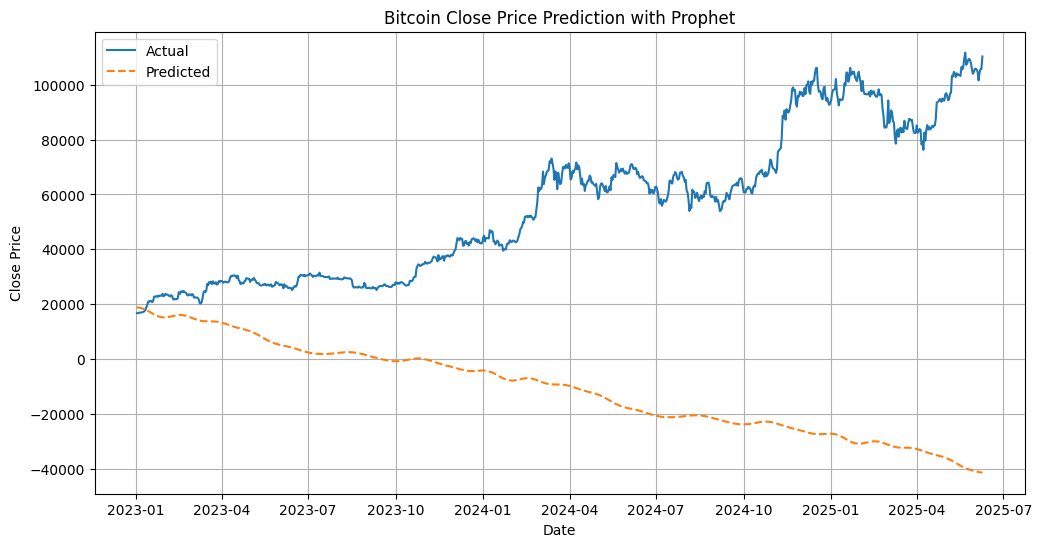

In [ ]:
# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(train_fb)

# Create future dataframe for predictions (same length as test set)
future = model.make_future_dataframe(periods=len(test_fb), freq='D')

# Generate forecasts
forecast = model.predict(future)

# Extract the predictions corresponding to the test set
y_valid = test_fb['y'].values
forecast_test = forecast.tail(len(test_fb))['yhat'].values

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_valid, forecast_test))
mae = mean_absolute_error(y_valid, forecast_test)
r2 = r2_score(y_valid, forecast_test)

# Print metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_fb['ds'], y_valid, label='Actual')
plt.plot(test_fb['ds'], forecast_test, label='Predicted', linestyle='--')
plt.title('Bitcoin Close Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Rolling Prophet

  0%|          | 0/890 [00:00<?, ?it/s]15:15:30 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/890 [00:05<1:24:10,  5.68s/it]15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/890 [00:08<59:58,  4.05s/it]  15:15:38 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/890 [00:11<50:48,  3.44s/it]15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/890 [00:13<42:54,  2.91s/it]15:15:43 - cmdstanpy - INFO - Chain [1] start processing
15:15:45 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/890 [00:17<49:24,  3.35s/it]15:15:47 - cmdstanpy - INFO - Chain [1] start processing
15:15:48 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/890 [00:19<42:49,  2.91s/

Rolling RMSE: 13508.82
Rolling MAE: 11789.88
Rolling R²: 0.749


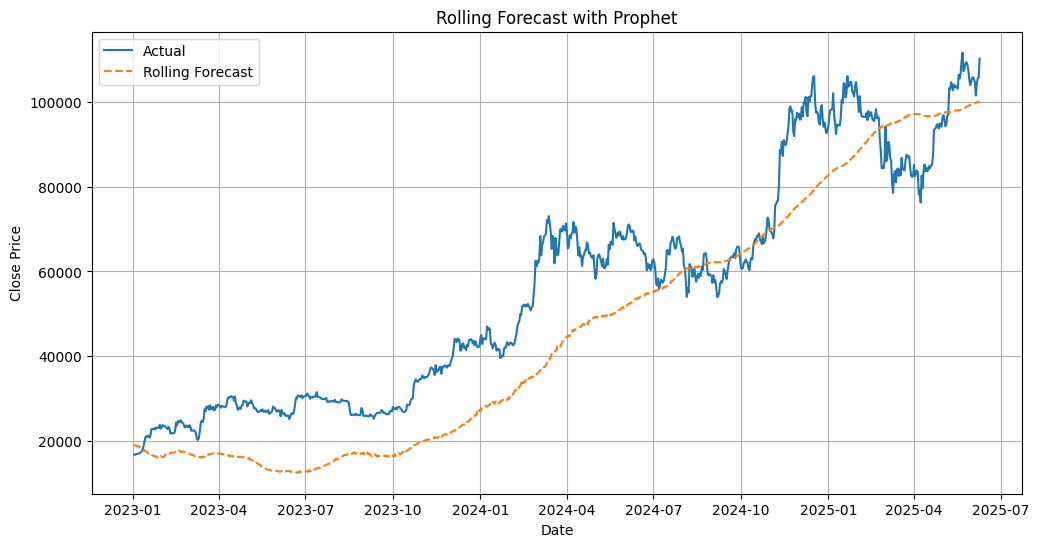

In [ ]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Combine train and test for rolling loop
full_data = pd.concat([train_fb, test_fb]).reset_index(drop=True)

# Rolling forecast setup
initial_window = len(train_fb)
horizon = 1
y_pred = []
y_true = []

# Rolling forecast loop
for i in tqdm(range(initial_window, len(full_data))):
    train_window = full_data.iloc[:i]
    test_point = full_data.iloc[i:i+horizon]

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(train_window)

    future = model.make_future_dataframe(periods=horizon, freq='D')
    forecast = model.predict(future)

    pred = forecast.iloc[-horizon:]['yhat'].values
    actual = test_point['y'].values

    y_pred.extend(pred)
    y_true.extend(actual)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Rolling RMSE: {rmse:.2f}")
print(f"Rolling MAE: {mae:.2f}")
print(f"Rolling R²: {r2:.3f}")

# Plot results
test_dates = full_data.iloc[initial_window:]['ds']

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label='Actual')
plt.plot(test_dates, y_pred, label='Rolling Forecast', linestyle='--')
plt.title('Rolling Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of gradient boosted decision trees designed for speed and performance. It is widely used for supervised learning tasks, including classification and regression. XGBoost offers features like regularization, parallel processing, and handling missing values, which help improve model accuracy and prevent overfitting. Its scalability and flexibility make it a popular choice in machine learning competitions and real-world applications.


INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling exogenous variables...
INFO:__main__:Running GridSearchCV to determine best hyperparameters...


Fitting 3 folds for each of 16 candidates, totalling 48 fits


INFO:__main__:Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
INFO:__main__:Fitting XGBoost model...
INFO:__main__:Generating forecasts...


Validation RMSE: 21370.0348
Validation MAE: 14337.5765
Validation R² Score: 0.3732


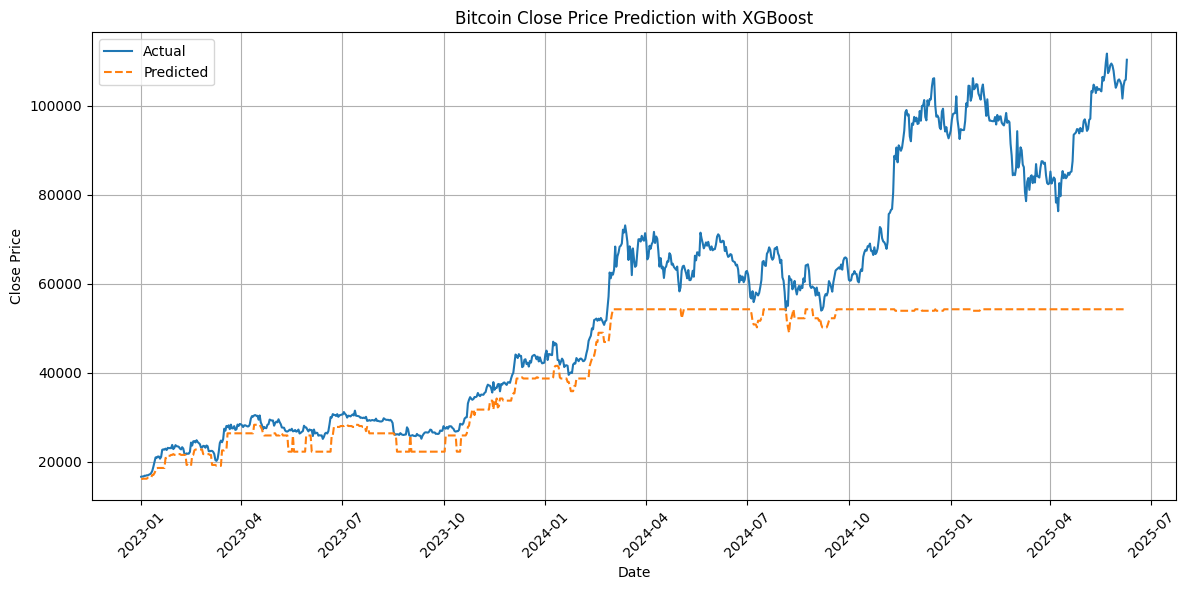

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


try:
    # Clean and prepare data
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    # Ensure numeric data and drop NaNs
    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    # Scale exogenous variables
    logger.info("Scaling exogenous variables...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Define XGBoost model and hyperparameter grid
    logger.info("Running GridSearchCV to determine best hyperparameters...")
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    logger.info(f"Best hyperparameters: {grid_search.best_params_}")

    # Fit the best model
    logger.info("Fitting XGBoost model...")
    best_model.fit(X_train_scaled, y_train)

    # Forecast
    logger.info("Generating forecasts...")
    forecast = best_model.predict(X_valid_scaled)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid, forecast))
    mae = mean_absolute_error(y_valid, forecast)
    r2 = r2_score(y_valid, forecast)

    print(f'Validation RMSE: {rmse:.4f}')
    print(f'Validation MAE: {mae:.4f}')
    print(f'Validation R² Score: {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'], y_valid, label='Actual')
    plt.plot(df_valid['Timestamp'], forecast, label='Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction with XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

# Rolling XGBoost

INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating training sequences...
INFO:__main__:Training XGBoost model once on training data...
INFO:__main__:Rolling window forecast starting...
Rolling XGBoost Forecast: 100%|██████████| 884/884 [00:00<00:00, 909.68it/s]


Rolling Validation RMSE: 19620.4569
Rolling Validation MAE: 12422.2583
Rolling Validation R² Score: 0.4669


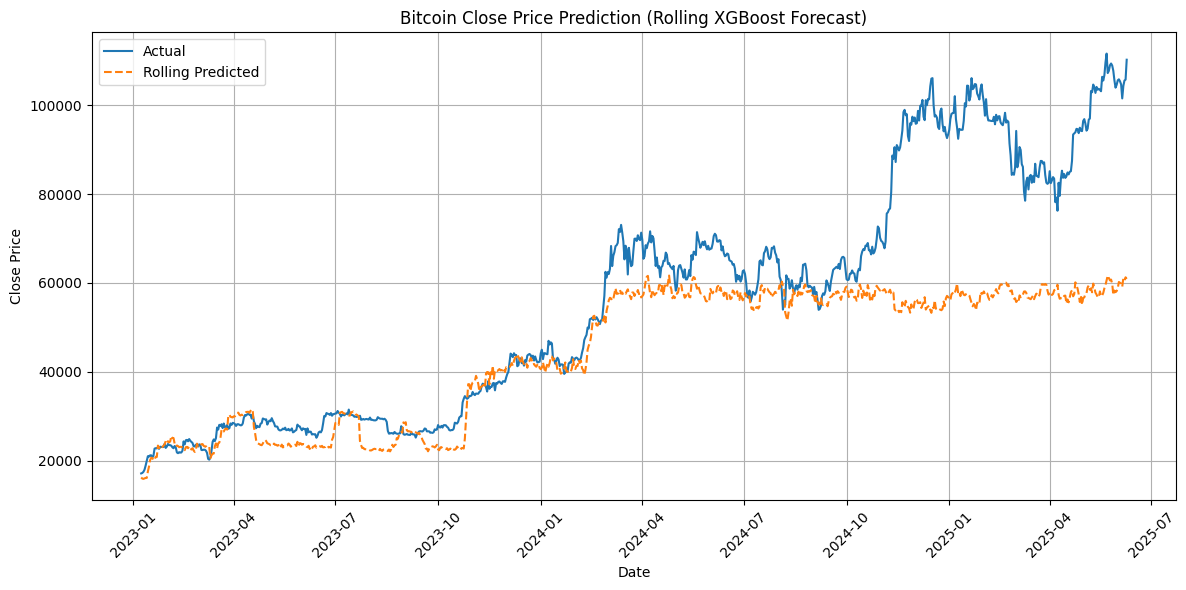

In [28]:
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    timesteps = 7

    def create_sequences(X, y, timesteps, n_features):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            # Flatten the sequence of timesteps * n_features into a single row
            Xs.append(X[i:i + timesteps].flatten())
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info("Creating training sequences...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps, len(exogenous_features))

    # Define the XGBoost model
    def create_xgboost_model():
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        return model

    logger.info("Training XGBoost model once on training data...")
    model = create_xgboost_model()
    model.fit(X_train_seq, y_train_seq)

    logger.info("Rolling window forecast starting...")
    rolling_predictions = []

    # Rolling forecast: step-by-step predict next value
    for t in tqdm(range(timesteps, len(X_valid_scaled)), desc="Rolling XGBoost Forecast"):
        X_input = X_valid_scaled[t - timesteps:t].flatten().reshape(1, -1)
        pred_scaled = model.predict(X_input)[0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        rolling_predictions.append(pred)

    y_valid_adjusted = y_valid[timesteps:]

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, rolling_predictions))
    mae = mean_absolute_error(y_valid_adjusted, rolling_predictions)
    r2 = r2_score(y_valid_adjusted, rolling_predictions)

    print(f'Rolling Validation RMSE: {rmse:.4f}')
    print(f'Rolling Validation MAE: {mae:.4f}')
    print(f'Rolling Validation R² Score: {r2:.4f}')

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], rolling_predictions, label='Rolling Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction (Rolling XGBoost Forecast)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

### LSTM (Long Short-Term Memory)

LSTM is a type of recurrent neural network (RNN) architecture designed to effectively capture long-term dependencies in sequential data. It addresses the vanishing gradient problem of traditional RNNs by using special memory cells and gates (input, forget, and output gates) to control the flow of information. LSTMs are widely used in time series forecasting, natural language processing, and speech recognition tasks where understanding context over time is crucial.


INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating sequences with 7 timesteps...
INFO:__main__:Running hyperparameter tuning...
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 50}
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 50}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate':

Validation RMSE: 19569.2051
Validation MAE: 13504.6108
Validation R² Score: 0.4697


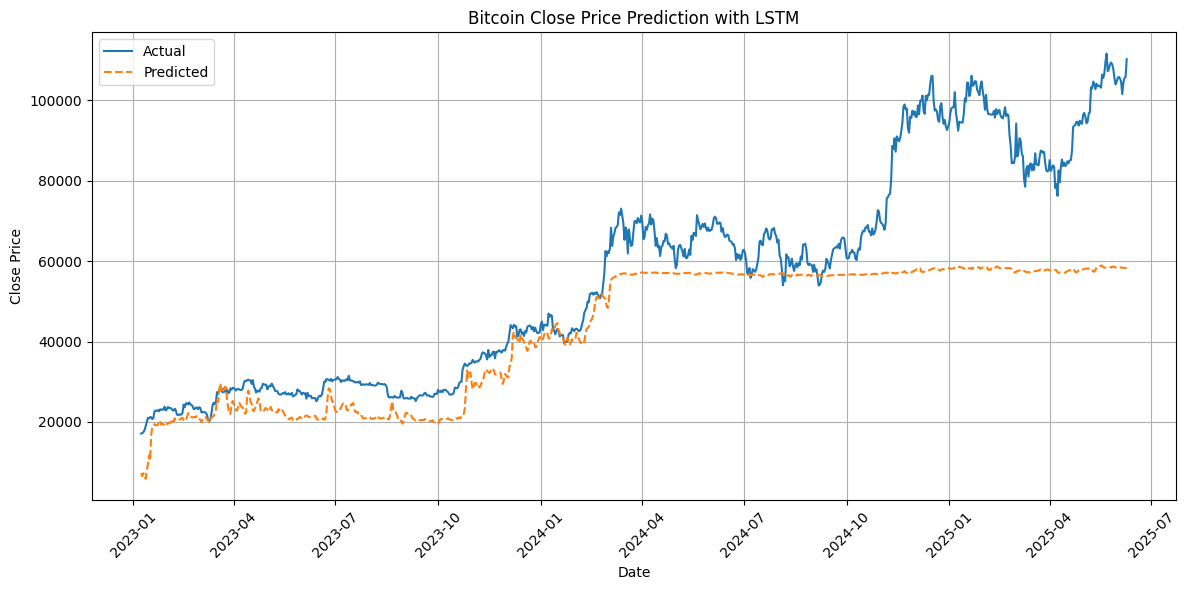

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    # Clean and prepare data
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    # Ensure numeric data and drop NaNs
    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    # Scale exogenous variables and target
    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    # Reshape data for LSTM [samples, timesteps, features]
    timesteps = 7  # Number of timesteps for sequential input
    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info(f"Creating sequences with {timesteps} timesteps...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_valid_seq, y_valid_seq = create_sequences(X_valid_scaled, y_valid_scaled, timesteps)

    # Define LSTM model creation function
    def create_lstm_model(units, dropout_rate, learning_rate):
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=units // 2))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    # Hyperparameter grid
    logger.info("Running hyperparameter tuning...")
    param_grid = {
        'units': [50, 100],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.01],
        'batch_size': [32, 64]
    }

    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Manual grid search
    for params in ParameterGrid(param_grid):
        logger.info(f"Testing parameters: {params}")
        model = create_lstm_model(params['units'], params['dropout_rate'], params['learning_rate'])
        history = model.fit(
            X_train_seq, y_train_seq,
            epochs=20,
            batch_size=params['batch_size'],
            validation_split=0.2,
            verbose=0,
            shuffle=False
        )
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params

    logger.info(f"Best hyperparameters: {best_params}")

    # Fit the best model
    logger.info("Fitting best LSTM model...")
    best_model.fit(
        X_train_seq, y_train_seq,
        epochs=20,
        batch_size=best_params['batch_size'],
        verbose=0,
        shuffle=False
    )

    # Forecast
    logger.info("Generating forecasts...")
    forecast_scaled = best_model.predict(X_valid_seq, verbose=0)
    forecast = scaler_y.inverse_transform(forecast_scaled).flatten()

    # Adjust y_valid for sequences (remove first timesteps)
    y_valid_adjusted = y_valid[timesteps:]

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, forecast))
    mae = mean_absolute_error(y_valid_adjusted, forecast)
    r2 = r2_score(y_valid_adjusted, forecast)

    print(f'Validation RMSE: {rmse:.4f}')
    print(f'Validation MAE: {mae:.4f}')
    print(f'Validation R² Score: {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], forecast, label='Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction with LSTM')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

# Rolling LSTM

INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating training sequences...
INFO:__main__:Training LSTM model once on training data...
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Rolling window forecast starting...
Rolling LSTM Forecast: 100%|██████████| 884/884 [01:45<00:00,  8.37it/s]


Rolling Validation RMSE: 13758.8529
Rolling Validation MAE: 8646.9282
Rolling Validation R² Score: 0.7378


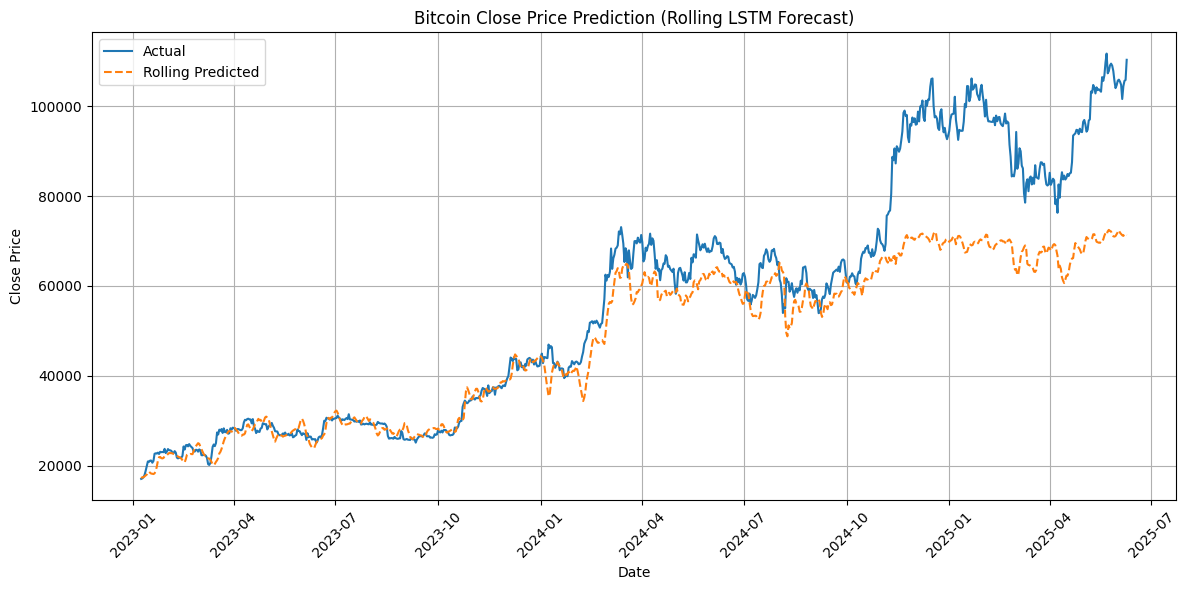

In [ ]:
from tqdm import tqdm

# ------------------------
# Set up logging
# ------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    timesteps = 7

    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info("Creating training sequences...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)

    # Define the LSTM model
    def create_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
        model = Sequential()
        model.add(LSTM(units=units, return_sequences=True, input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units=units // 2))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    logger.info("Training LSTM model once on training data...")
    model = create_lstm_model()
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)

    logger.info("Rolling window forecast starting...")
    rolling_predictions = []

    # Rolling forecast: step-by-step predict next value
    for t in tqdm(range(timesteps, len(X_valid_scaled)), desc="Rolling LSTM Forecast"):
        X_input = X_valid_scaled[t - timesteps:t].reshape(1, timesteps, len(exogenous_features))
        pred_scaled = model.predict(X_input, verbose=0)[0][0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        rolling_predictions.append(pred)

    y_valid_adjusted = y_valid[timesteps:]

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, rolling_predictions))
    mae = mean_absolute_error(y_valid_adjusted, rolling_predictions)
    r2 = r2_score(y_valid_adjusted, rolling_predictions)

    print(f'Rolling Validation RMSE: {rmse:.4f}')
    print(f'Rolling Validation MAE: {mae:.4f}')
    print(f'Rolling Validation R² Score: {r2:.4f}')

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], rolling_predictions, label='Rolling Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction (Rolling LSTM Forecast)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise


# GRU

GRU is a type of recurrent neural network (RNN) that simplifies the architecture of LSTM by combining the forget and input gates into a single update gate. This results in fewer parameters and faster training while still effectively capturing dependencies in sequential data. GRUs are commonly used in time series prediction, language modeling, and speech processing tasks, offering a good balance between performance and computational efficiency.

INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating sequences with 7 timesteps...
INFO:__main__:Running hyperparameter tuning...
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 50}
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 50}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate':

Validation RMSE: 23187.8013
Validation MAE: 18347.4306
Validation R² Score: 0.2554


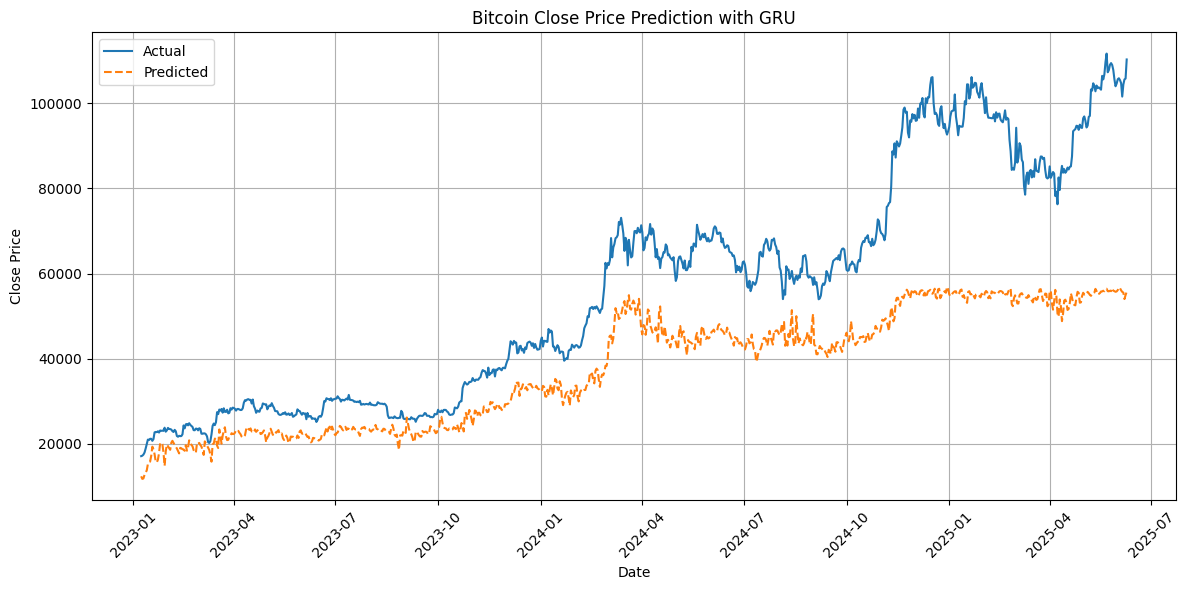

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    # Clean and prepare data
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    # Ensure numeric data and drop NaNs
    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    # Scale exogenous variables and target
    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    # Reshape data for GRU [samples, timesteps, features]
    timesteps = 7  # Number of timesteps for sequential input
    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info(f"Creating sequences with {timesteps} timesteps...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_valid_seq, y_valid_seq = create_sequences(X_valid_scaled, y_valid_scaled, timesteps)

    # Define GRU model creation function
    def create_gru_model(units, dropout_rate, learning_rate):
        model = Sequential()
        model.add(GRU(units=units, return_sequences=True, input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(GRU(units=units // 2))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    # Hyperparameter grid
    logger.info("Running hyperparameter tuning...")
    param_grid = {
        'units': [50, 100],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.01],
        'batch_size': [32, 64]
    }

    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Manual grid search
    for params in ParameterGrid(param_grid):
        logger.info(f"Testing parameters: {params}")
        model = create_gru_model(params['units'], params['dropout_rate'], params['learning_rate'])
        history = model.fit(
            X_train_seq, y_train_seq,
            epochs=20,
            batch_size=params['batch_size'],
            validation_split=0.2,
            verbose=0,
            shuffle=False
        )
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params

    logger.info(f"Best hyperparameters: {best_params}")

    # Fit the best model
    logger.info("Fitting best GRU model...")
    best_model.fit(
        X_train_seq, y_train_seq,
        epochs=20,
        batch_size=best_params['batch_size'],
        verbose=0,
        shuffle=False
    )

    # Forecast
    logger.info("Generating forecasts...")
    forecast_scaled = best_model.predict(X_valid_seq, verbose=0)
    forecast = scaler_y.inverse_transform(forecast_scaled).flatten()

    # Adjust y_valid for sequences (remove first timesteps)
    y_valid_adjusted = y_valid[timesteps:]

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, forecast))
    mae = mean_absolute_error(y_valid_adjusted, forecast)
    r2 = r2_score(y_valid_adjusted, forecast)

    print(f'Validation RMSE: {rmse:.4f}')
    print(f'Validation MAE: {mae:.4f}')
    print(f'Validation R² Score: {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], forecast, label='Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction with GRU')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

# Rolling GRU

INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating training sequences...
INFO:__main__:Training GRU model once on training data...
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Rolling window forecast starting...
Rolling GRU Forecast: 100%|██████████| 884/884 [01:09<00:00, 12.75it/s]


Rolling Validation RMSE: 14071.3871
Rolling Validation MAE: 8682.2517
Rolling Validation R² Score: 0.7258


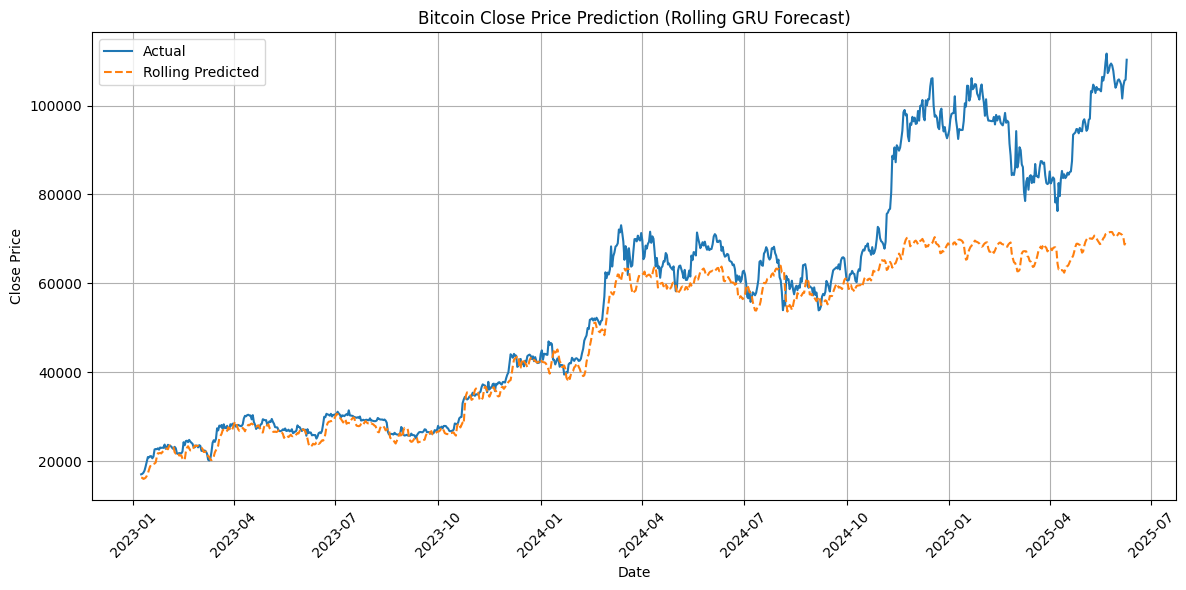

In [26]:
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    timesteps = 7

    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info("Creating training sequences...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)

    # Define the GRU model
    def create_gru_model(units=50, dropout_rate=0.2, learning_rate=0.001):
        model = Sequential()
        model.add(GRU(units=units, return_sequences=True, input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(GRU(units=units // 2))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    logger.info("Training GRU model once on training data...")
    model = create_gru_model()
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)

    logger.info("Rolling window forecast starting...")
    rolling_predictions = []

    # Rolling forecast: step-by-step predict next value
    for t in tqdm(range(timesteps, len(X_valid_scaled)), desc="Rolling GRU Forecast"):
        X_input = X_valid_scaled[t - timesteps:t].reshape(1, timesteps, len(exogenous_features))
        pred_scaled = model.predict(X_input, verbose=0)[0][0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        rolling_predictions.append(pred)

    y_valid_adjusted = y_valid[timesteps:]

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, rolling_predictions))
    mae = mean_absolute_error(y_valid_adjusted, rolling_predictions)
    r2 = r2_score(y_valid_adjusted, rolling_predictions)

    print(f'Rolling Validation RMSE: {rmse:.4f}')
    print(f'Rolling Validation MAE: {mae:.4f}')
    print(f'Rolling Validation R² Score: {r2:.4f}')

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], rolling_predictions, label='Rolling Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction (Rolling GRU Forecast)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

### Bidirectional LSTM

Bidirectional LSTM (BiLSTM) is an extension of the traditional LSTM that processes data in both forward and backward directions. This allows the model to have information from past (previous time steps) and future (upcoming time steps) simultaneously, improving context understanding in sequence data. BiLSTMs are especially useful in tasks like speech recognition, language modeling, and time series forecasting where context from both directions enhances prediction accuracy.


INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating sequences with 7 timesteps...
INFO:__main__:Running hyperparameter tuning...
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 50}
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 50}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'units': 100}
INFO:__main__:Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learn

Validation RMSE: 29041.8558
Validation MAE: 21134.7300
Validation R² Score: -0.1680


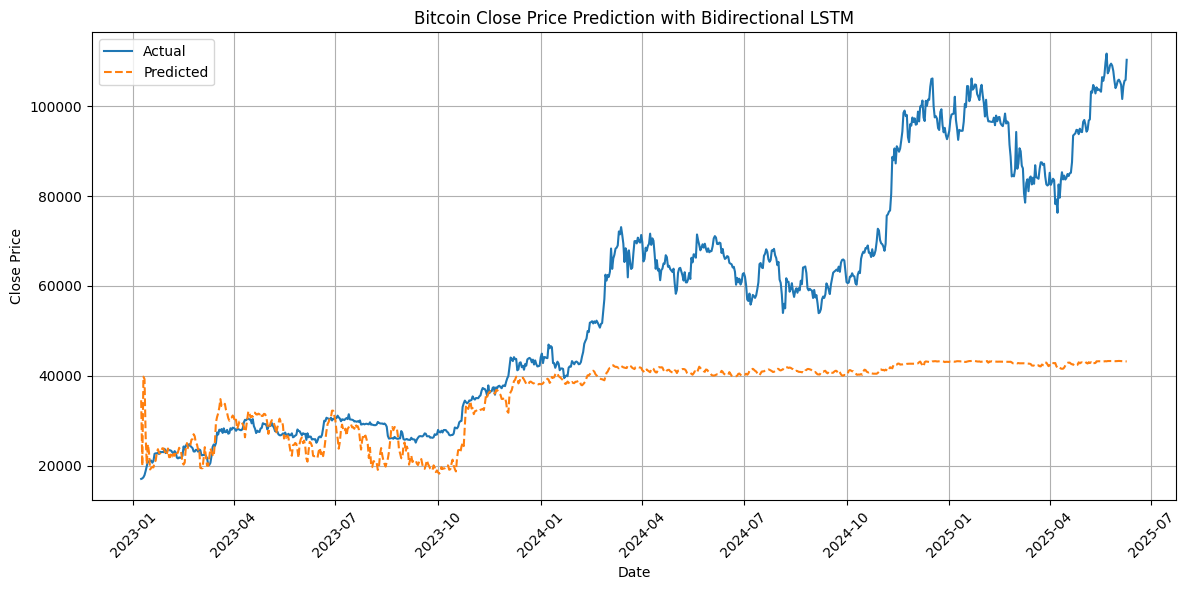

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    # Clean and prepare data
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    # Ensure numeric data and drop NaNs
    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    # Scale exogenous variables and target
    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    # Reshape data for Bidirectional LSTM [samples, timesteps, features]
    timesteps = 7  # Number of timesteps for sequential input
    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info(f"Creating sequences with {timesteps} timesteps...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_valid_seq, y_valid_seq = create_sequences(X_valid_scaled, y_valid_scaled, timesteps)

    # Define Bidirectional LSTM model creation function
    def create_bidirectional_lstm_model(units, dropout_rate, learning_rate):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(units=units // 2)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    # Hyperparameter grid
    logger.info("Running hyperparameter tuning...")
    param_grid = {
        'units': [50, 100],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.01],
        'batch_size': [32, 64]
    }

    best_val_loss = float('inf')
    best_model = None
    best_params = None

    # Manual grid search
    for params in ParameterGrid(param_grid):
        logger.info(f"Testing parameters: {params}")
        model = create_bidirectional_lstm_model(params['units'], params['dropout_rate'], params['learning_rate'])
        history = model.fit(
            X_train_seq, y_train_seq,
            epochs=20,
            batch_size=params['batch_size'],
            validation_split=0.2,
            verbose=0,
            shuffle=False
        )
        val_loss = min(history.history['val_loss'])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_params = params

    logger.info(f"Best hyperparameters: {best_params}")

    # Fit the best model
    logger.info("Fitting best Bidirectional LSTM model...")
    best_model.fit(
        X_train_seq, y_train_seq,
        epochs=20,
        batch_size=best_params['batch_size'],
        verbose=0,
        shuffle=False
    )

    # Forecast
    logger.info("Generating forecasts...")
    forecast_scaled = best_model.predict(X_valid_seq, verbose=0)
    forecast = scaler_y.inverse_transform(forecast_scaled).flatten()

    # Adjust y_valid for sequences (remove first timesteps)
    y_valid_adjusted = y_valid[timesteps:]

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, forecast))
    mae = mean_absolute_error(y_valid_adjusted, forecast)
    r2 = r2_score(y_valid_adjusted, forecast)

    print(f'Validation RMSE: {rmse:.4f}')
    print(f'Validation MAE: {mae:.4f}')
    print(f'Validation R² Score: {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], forecast, label='Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction with Bidirectional LSTM')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

# Rolling Bidirectional LSTM

INFO:__main__:Preparing and cleaning data...
INFO:__main__:Scaling variables...
INFO:__main__:Creating training sequences...
INFO:__main__:Training Bidirectional LSTM model once on training data...
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Rolling window forecast starting...
Rolling Bidirectional LSTM Forecast: 100%|██████████| 884/884 [01:10<00:00, 12.56it/s]


Rolling Validation RMSE: 13358.0576
Rolling Validation MAE: 8211.6940
Rolling Validation R² Score: 0.7529


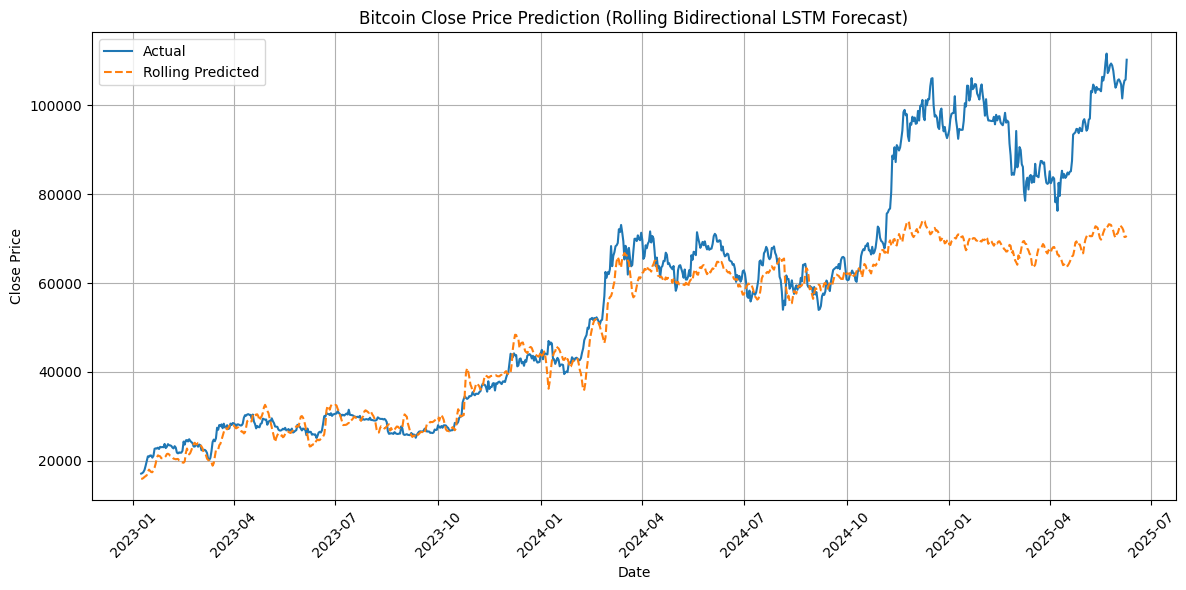

In [27]:
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    logger.info("Preparing and cleaning data...")
    df_train_clean = df_train[[target_col] + exogenous_features].copy()
    df_valid_clean = df_valid[[target_col] + exogenous_features].copy()

    df_train_clean = df_train_clean.apply(pd.to_numeric, errors='coerce').dropna()
    df_valid_clean = df_valid_clean.apply(pd.to_numeric, errors='coerce').dropna()

    X_train = df_train_clean[exogenous_features].reset_index(drop=True)
    y_train = df_train_clean[target_col].reset_index(drop=True)
    X_valid = df_valid_clean[exogenous_features].reset_index(drop=True)
    y_valid = df_valid_clean[target_col].reset_index(drop=True)

    logger.info("Scaling variables...")
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_valid_scaled = scaler_X.transform(X_valid)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()

    timesteps = 7

    def create_sequences(X, y, timesteps):
        Xs, ys = [], []
        for i in range(len(X) - timesteps):
            Xs.append(X[i:i + timesteps])
            ys.append(y[i + timesteps])
        return np.array(Xs), np.array(ys)

    logger.info("Creating training sequences...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)

    # Define the Bidirectional LSTM model
    def create_bidirectional_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(timesteps, len(exogenous_features))))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(units=units // 2)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    logger.info("Training Bidirectional LSTM model once on training data...")
    model = create_bidirectional_lstm_model()
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)

    logger.info("Rolling window forecast starting...")
    rolling_predictions = []

    # Rolling forecast: step-by-step predict next value
    for t in tqdm(range(timesteps, len(X_valid_scaled)), desc="Rolling Bidirectional LSTM Forecast"):
        X_input = X_valid_scaled[t - timesteps:t].reshape(1, timesteps, len(exogenous_features))
        pred_scaled = model.predict(X_input, verbose=0)[0][0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        rolling_predictions.append(pred)

    y_valid_adjusted = y_valid[timesteps:]

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid_adjusted, rolling_predictions))
    mae = mean_absolute_error(y_valid_adjusted, rolling_predictions)
    r2 = r2_score(y_valid_adjusted, rolling_predictions)

    print(f'Rolling Validation RMSE: {rmse:.4f}')
    print(f'Rolling Validation MAE: {mae:.4f}')
    print(f'Rolling Validation R² Score: {r2:.4f}')

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_valid['Timestamp'][timesteps:], y_valid_adjusted, label='Actual')
    plt.plot(df_valid['Timestamp'][timesteps:], rolling_predictions, label='Rolling Predicted', linestyle='--')
    plt.title('Bitcoin Close Price Prediction (Rolling Bidirectional LSTM Forecast)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    raise

### Why Model Results May Change Across Runs

- **GRU Initialization is Random:**  
  Keras initializes GRU (and other layer) weights randomly by default. Without setting a fixed random seed, these initial values will differ on each run, leading to variation in results.

- **Dropout Layers:**  
  Dropout randomly deactivates a subset of neurons during training to prevent overfitting. This stochastic behavior introduces slight randomness in model training unless a seed is set.

- **Training Behavior:**  
  Even with the same model and data, if data shuffling is not controlled, the order in which the model sees the data can vary, affecting the learned weights and final performance.


In [ ]:
df_train

,Timestamp,Open,High,Low,Close,Volume_(Currency),Open_mean_lag3,Open_std_lag3,High_mean_lag3,High_std_lag3,...,Low_mean_lag30,Low_std_lag30,Close_mean_lag30,Close_std_lag30,Volume_(Currency)_mean_lag30,Volume_(Currency)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,22580.005228,460.721160,23071.460279,407.689260,...,21707.792318,1451.369339,22241.994704,1457.521699,1.940640e+10,6.309771e+09,9,38,17,2
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,465.864014,460.721160,468.174011,407.689260,...,452.421997,1451.369339,457.334015,1457.521699,2.105680e+07,6.309771e+09,9,38,18,3
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,461.362000,6.366809,462.516998,8.000224,...,432.763000,27.802020,440.887009,23.259579,2.777000e+07,9.493898e+06,9,38,19,4
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,448.942332,21.977547,450.956329,20.807426,...,416.686005,34.086442,425.523336,31.283084,3.115323e+07,8.910996e+06,9,38,20,5
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,425.211995,31.108320,435.996989,18.209863,...,409.985252,30.889977,421.368500,26.860222,3.258082e+07,7.815965e+06,9,38,21,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,16828.910807,27.780443,16881.793620,33.259001,...,16788.301986,337.072698,16955.040039,348.372730,1.894180e+10,5.178076e+09,12,52,27,1
2022-12-28,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920,16869.682292,43.042713,16913.507812,49.974968,...,16795.136882,331.740889,16964.124935,338.002549,1.878529e+10,5.202012e+09,12,52,28,2
2022-12-29,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,14472237479,16825.980469,102.419113,16882.712891,101.165909,...,16809.904427,306.539189,16975.299935,317.372886,1.842738e+10,4.926529e+09,12,52,29,3


In [ ]:
df_valid

,Timestamp,Open,High,Low,Close,Volume_(Currency),Open_mean_lag3,Open_std_lag3,High_mean_lag3,High_std_lag3,...,Low_mean_lag30,Low_std_lag30,Close_mean_lag30,Close_std_lag30,Volume_(Currency)_mean_lag30,Volume_(Currency)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01,2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,9244361700,16599.108724,44.679165,16641.389974,11.520731,...,16808.618294,292.067116,16949.024674,322.408336,1.728204e+10,4.427169e+09,1,52,1,6
2023-01-02,2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703,12097775227,16597.639323,46.999462,16634.284505,7.951533,...,16796.730078,296.377271,16933.572005,326.567594,1.693887e+10,4.640040e+09,1,1,2,0
2023-01-03,2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422,13903079207,16592.365885,40.014691,16672.923177,74.845938,...,16786.199674,298.621171,16926.246484,329.606257,1.680153e+10,4.722359e+09,1,1,3,1
2023-01-04,2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281,18421743322,16620.757161,70.586896,16716.743490,74.743525,...,16776.830729,299.224563,16911.225521,330.245104,1.670415e+10,4.751898e+09,1,1,4,2
2023-01-05,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,13692758566,16664.854167,34.346178,16828.125651,118.179363,...,16768.341797,298.563166,16907.505924,330.132455,1.657791e+10,4.649817e+09,1,1,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,2025-06-05,104750.781250,105936.687500,100436.882812,101575.953125,57479298400,105657.552083,227.153598,106256.528646,482.820715,...,103474.107031,3525.472682,105210.660417,3216.954535,5.170892e+10,1.239993e+10,6,23,5,3
2025-06-06,2025-06-06,101574.367188,105376.773438,101169.570312,104390.343750,48856653697,105357.875000,572.691843,106249.320312,489.612753,...,103708.674479,3031.577374,105369.776302,2887.960164,5.273986e+10,1.148837e+10,6,23,6,4
2025-06-07,2025-06-07,104390.648438,105972.757812,103987.312500,105615.625000,38365033776,103919.838542,2059.793518,105770.385417,342.240092,...,103886.682292,2690.570062,105615.043750,2431.903862,5.180229e+10,1.055108e+10,6,23,7,5
